In [ ]:
pip install -q -U faiss-gpu sentence_transformers rank_bm25 PyMuPDF

In [ ]:
# data handling and system operations
import os 
import re
import sqlite3
import time
import gc

# mathematical operations, data handling, and machine learning
import random
import numpy as np
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi

# visualization
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from IPython.display import HTML, Markdown, display, Image
from tqdm.auto import tqdm
import markdown as mkd

# model
import torch
import transformers 
from transformers import AutoModelForCausalLM, AutoTokenizer

# clean text
from bs4 import BeautifulSoup # (For meta-kaggle clean ForumMessages.csv)

In [ ]:
# Section 1.1. Visualization 
def display_search_results(question, searched_documents):
    style = """
    <style>
    .results-container {
        display: flex;
        flex-wrap: wrap;
        gap: 15px;  /* Controls space between rows and columns */
    }
    .document-result {
        flex: 1 0 48%; /* Adjusts so each box takes up roughly half the space, less the gap */
        border: 1px solid #ddd;
        padding: 10px;
        background-color: #e8f5e9;
        box-sizing: border-box; /* Ensures padding is included in width calculation */
        min-width: 280px; /* Ensures that flex items have a minimum width */
        max-width: 48%; /* Ensures that items do not exceed the set percentage */
        margin-bottom: 15px; /* Maintains spacing for the last row if less than two items */
    }
    .content-wrapper {
        background-color: #ffffff; /* Calm white tone */
        padding: 10px;
        border-radius: 5px; /* Soft rounded corners for the inner content */
        box-shadow: 0 2px 4px rgba(0,0,0,0.1); /* Subtle shadow for depth */
    }
    </style>
    """
    html_content = style + f""" 
    <h3>Question: {question}</h3>
    <div class="results-container">
    """
    for document_number, document_content in enumerate(searched_documents):
        html_content += f"""
        <div class="document-result">
            <div class="content-wrapper">
                <h4>Document {document_number+1}:</h4>
                <p>{document_content}</p>
                <p>Length: {len(document_content)}</p>
            </div>
        </div>
        """
    html_content += "</div>"  # Close the container div
    display(HTML(html_content))
    
    
    
# Section 1.4. Visualization
def add_colored_lines_with_markdown(text, color="orange"):
    """Adds colored line separators to the model's response and converts Markdown to HTML using the markdown library."""
    # Convert Markdown text to HTML
    html_text = mkd.markdown(text)

    # Wrap the HTML text with line separators
    line_separator = f"<hr style='border: 1px solid {color};'>"
    html_styled_text = f"{line_separator}<div style='margin-top: 10px;'>{html_text}</div>{line_separator}"
    
    return html_styled_text

# Section 1.4. Visualization
def display_question_answers(question, answers, tags=None, colors=None):
    html_content = "<table style='width:100%;'><tr>"

    # Generate a list of colors from matplotlib's colormap
    if colors is None:
        cmap = plt.get_cmap('tab20')  # This colormap has nice, distinct colors
        color_indices = np.linspace(0, 1, len(answers))
        colors = [cmap(i) for i in color_indices]
        # Convert RGBA colors to hex
        colors = [rgb2hex(c) for c in colors]

    # If tags are not provided, use default tags as "Answer 1", "Answer 2", etc.
    if tags is None:
        tags = [f"Answer {i + 1}" for i in range(len(answers))]

    # Create table headers using tags
    for tag in tags:
        html_content += f"<th style='text-align:left;'>{tag}</th>"
    
    html_content += "</tr><tr>"
    
    # Process each answer, applying colors and tags
    for idx, answer in enumerate(answers):
        # Use provided or generated color for each answer
        color = colors[idx] if idx < len(colors) else "black"
        
        # Construct the answer HTML
        tag_text = f"<b>{tags[idx]}:</b><br>"
        color_text = add_colored_lines_with_markdown(answer if answer else "No answer provided.", color=color)
        answer_html = f"{tag_text}<b>Question:</b> {question}<br>{color_text}"
        
        html_content += f"<td style='vertical-align:top; text-align:left; padding: 10px 20px 10px 10px; border-right: 1px solid lightgray;'>{answer_html}</td>"

    html_content += "</tr></table>"
    
    display(HTML(html_content))
    
    
# 3.2. Visualization
def display_competition_search_results(topic, searched_documents):
    style = """
    <style>
    .custom-results-container {
        display: flex;
        flex-wrap: wrap;
        gap: 20px;  /* Controls space between rows and columns */
        justify-content: flex-start; /* Ensures items align to the left */
    }
    .custom-competition-result {
        flex: 0 0 48%; /* Do not grow, do not shrink, initial width at 48% */
        max-width: 48%; /* Ensures that items do not exceed the set percentage, aligning two per row */
        border: 1px solid #e0e0e0; /* Light grey border */
        padding: 10px;
        background-color: #e8f5e9; /* Light greenish background */
        box-sizing: border-box; /* Ensures padding is included in width calculation */
        margin-bottom: 20px; /* Space at the bottom of each box */
        box-shadow: 0 2px 6px rgba(0,0,0,0.05); /* Soft shadow for depth */
    }
    .custom-table {
        width: 100%;
        border-collapse: collapse;
    }
    .custom-th, .custom-td {
        padding: 8px;
        text-align: left;
        border-bottom: 1px solid #e0e0e0; /* Light grey for horizontal line under each row */
    }
    .custom-th {
        background-color: #fafafa; /* Very light grey for header background */
        width: 30%; /* Smaller width for labels */
    }
    .custom-td {
        word-wrap: break-word; /* Ensures text wraps to avoid overflow */
        color: #333; /* Darker text for better readability */
    }
    .custom-link {
        color: #5a5a5a; /* Subdued blue for links */
        text-decoration: none;
    }
    .custom-link:hover {
        text-decoration: underline;
        color: #2a2a2a; /* Darker shade for hover state */
    }
    </style>
    """
    html_content = style + f""" 
    <h3>Topic: {topic}</h3> 
    <div class="custom-results-container">
    """
    for document_number, (document_content,document_score) in enumerate(searched_documents):
        html_content += f"""
        <div class="custom-competition-result">
            <h4>Competition {document_number+1}:</h4>
            <table class="custom-table">
                <tr><th class="custom-th">Title</th><td class="custom-td">{document_content['Title']}</td></tr>
                <tr><th class="custom-th">Subtitle</th><td class="custom-td">{document_content['Subtitle']}</td></tr>
                <tr><th class="custom-th">Evaluation Metric</th><td class="custom-td">{document_content['EvaluationAlgorithmName']}</td></tr>
                <tr><th class="custom-th">Link</th><td class="custom-td"><a class="custom-link" href='{document_content['Link']}'>{document_content['Link']}</a></td></tr>
                <tr><th class="custom-th">Forum Id</th><td class="custom-td">{document_content['ForumId']}</td></tr>
                <tr><th class="custom-th">Period</th><td class="custom-td">{document_content['Period']}</td></tr>
                <tr><th class="custom-th">Score</th><td class="custom-td">{document_score}</td></tr>
            </table>
        </div>
        """
    html_content += "</div>"  # Close the container div
    display(HTML(html_content))

**Submission:** 2024-04-14, By Woosung Yoon


The fundamental purpose of this notebook is:
- To create a tutorial notebook for experimenting with the algorithms of the Gemma model, and
- `To explain or teach data science concepts`

In [ ]:
class CONFIG:
    gemma_model_path = "/kaggle/input/gemma/transformers/2b-it/3"
    
    faiss_index_path = "/kaggle/input/wiki-stem-retrieve/search_index.faiss"
    faiss_db_path = "/kaggle/input/wiki-stem-retrieve/documents.db"
    
    competition_csv_path = "/kaggle/input/meta-kaggle/Competitions.csv"
    forum_topic_csv_path = "/kaggle/input/meta-kaggle/ForumTopics.csv"
    forum_messages_csv_path = "/kaggle/input/meta-kaggle/ForumMessages.csv"
    
    results_csv_path = "/kaggle/input/ws-nb-figure/results_df.csv"
    example_short_text_path = "/kaggle/input/ws-nb-figure/example_short_text.csv"
    sample_presentation_pdf_path = "/kaggle/input/ws-nb-figure/sample_presentation.pdf"
    

In this project, we are developing the `heuristic algorithm` of the Gemma model to `explain or teach data science concepts`. 

We have faced some challenges but have also made progress in developing it. 

### Major Works

1. **Algorithm 1: Ensemble (Question-Answer):**   
Single answers sometimes included errors or were unstable. To improve this, we set up the ensemble like a parallel circuit. With this setup, even if one answer is incorrect, it is possible to correct it from another answer.

3. **Algorithm 2: Kaggle Competition Search and SWOT:**   
The number of Kaggle users increases every year. We thought we needed a way to utilize past competitions. We created one that uses Kaggle Meta data and the BM25 algorithm to find past competitions and SWOT analyze it.

2. **Algorithm 3: Chain of Ensemble (Document Refinement):**   
By stacking several Ensemble models, Each Ensemble model can answer a specific topic. This is designed to improve existing documents.

<div style="background-color: #ffeaa7; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">Algorithm 1: Ensemble (Question-Answer)</h2>
</div>

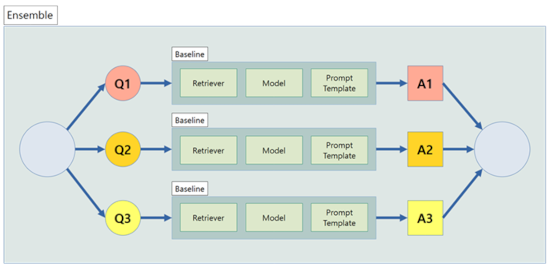

<div style="background-color: #ffeaa7; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">Algorithm 2: Search and SWOT Kaggle Competitions</h2>
</div>

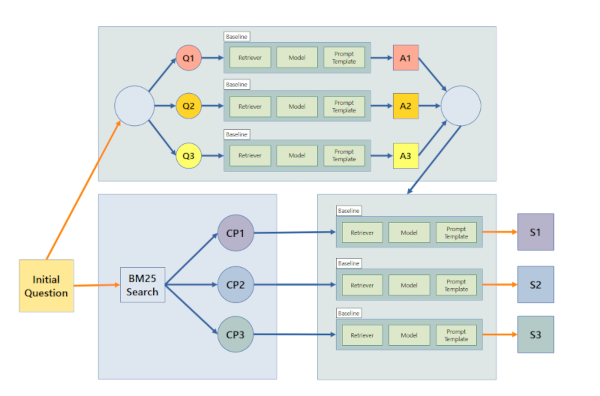

<div style="background-color: #ffeaa7; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">Algorithm 3: Chain of Ensemble Model (Document Refinement)</h2>
</div>

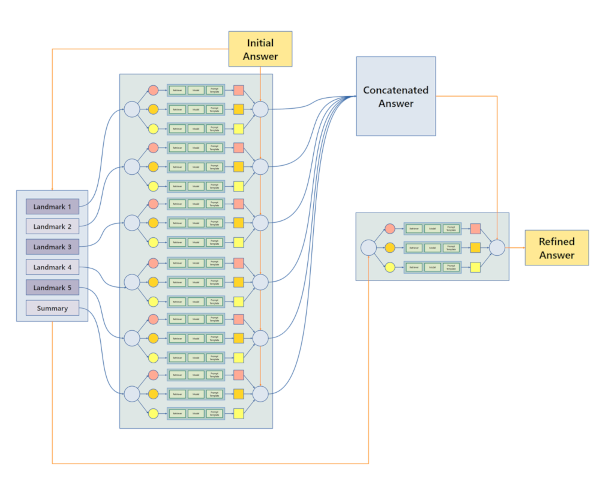

<div class="alert alert-block alert-success">
<b>Note:</b> The algorithms mentioned above are introduced in Sections 2, 3, and 4, respectively.
</div>

<div style="background-color: #4791db; color: white; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">Table of Contents</h2>
</div>

## **Table of Contents**
1. **Baseline Introduction** <br>
    *1.1. Faiss Retriever* <br>
    *1.2. Prompt Template* <br>
    *1.3. Gemma Model Wrapper* <br>
    *1.4. Examples of Baseline Model Answers*<br>

2. **Algorithm 1: Ensemble Model (Question-Answer)** <br>
   *2.1. Ensemble Model Implementation* <br>
   *2.2. Examples of Ensemble Model Answers* <br>

3. **Algorithm 2: Search and SWOT Kaggle Competitions** <br>
   *3.1. Prepare Kaggle Competition-Message Data* <br>
   *3.2. Competition BM25 Search (Okapi BM25)* <br>
   *3.3. Competition SWOT Summarize* <br>
   *3.4. Examples of Search and SWOT* <br>

4. **Algorithm 3: Chain of Ensemble Model (Document Refinement)** <br>
   *4.1. Chain of Ensemble Model Implementation* <br>
   *4.2. Examples of Chain Ensemble Model* <br>
   
5. **Performance Review** <br>
   *5.1. Data Science Answers* <br>
   *5.2. Competition Search and Summary* <br>
   *5.3. Conclusion* <br>
   
6. **Wrap All: Gemma Question Answering System for Kaggle** <br>
   *6.1. Question Answering System Implementation* <br>

7. **Application 1: Create a presentation script** <br>
   *7.1. Generate Transcripts* <br>

8. **Conclusion** <br>

9. **Reference** <br>

<div style="background-color: #4791db; color: white; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">1. Baseline Introduction</h2>
</div>

## 1. Baseline Introduction

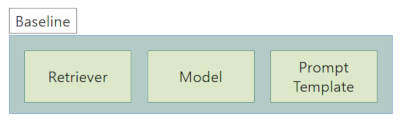

This baseline has three components:

1. **Retriever**: Finds documents from pre-processed Wikipedia articles

2. **Prompt Template**: Prompt template that can represent characters like Passage, User, and Model.

3. **Model**: Wrapper for the baseline model

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Faiss Retriever</h3>
</div>

### 1.1. Faiss Retriever

The `FaissRetriever` Class utilizes the `multi-qa-mpnet-base-dot-v1` embedding model.
- It has been trained on question-answer datasets including WikiAnswers and Stack Exchange [8]
- Retriever find an approximate answer like document to a given question

In [ ]:
class FaissRetriever:
    def __init__(self, db_path, index_path):
        """
        Initializes the FaissRetriever class which uses a sentence transformer model for embedding
        and FAISS for efficient similarity search.
        
        :param db_path: Path to the SQLite database containing the text data.
        :param index_path: Path to the stored FAISS index for fast retrieval.
        """
        self.embedding_model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')
        self.index_type = "Flat"
        self._index = None
        
        self.db_path = db_path
        self.index_path = index_path

    def load_index(self):
        """Loads the FAISS index from the specified file path."""
        self._index = faiss.read_index(self.index_path)

    def search(self, query, k=3):
        """
        Searches the index for the k most similar entries to the given query.
        
        :param query: A string or list of strings for which to find similar entries.
        :param k: Number of top results to retrieve (default is 3).
        :return: A list of lists containing the top k similar text entries for each query.
        """
        if isinstance(query, str):
            query = [query]
            
        query_embedding = self.embedding_model.encode(query, show_progress_bar=False)
        D, I = self._index.search(np.array(query_embedding).astype('float32'), k=k)

        chunk_ids_list = [[str(idx) for idx in query_indices] for query_indices in I]
        total_results = []

        # Use the context manager to handle the connection
        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.cursor()
            for chunk_ids in chunk_ids_list:
                placeholders = ','.join(['?'] * len(chunk_ids))
                cursor.execute(f"""
                    SELECT source_data
                    FROM text_data
                    WHERE text_data.source_id IN ({placeholders})
                """, chunk_ids)
                results = cursor.fetchall()
                results = [row[0] for row in results]
                total_results.append(results)

        return total_results

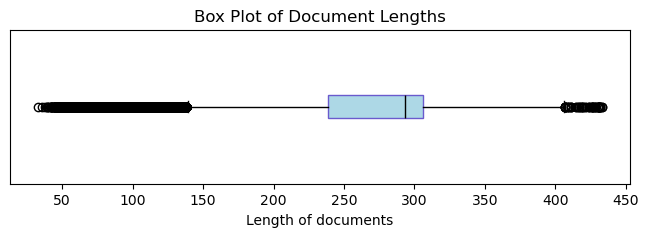

The `FaissRetriever` uses a Wikipedia dataset from Kaggle, mainly on STEM topics, ideal for data science. [10]
- Wikpedia STEM documents are split into near 250-character chunks (chunk_size=250, chunk_overlap=20)
- Titles and sections extends each chunk

In [ ]:
faiss_db_path = CONFIG.faiss_db_path
faiss_index_path = CONFIG.faiss_index_path

searchRetriever = FaissRetriever(faiss_db_path, faiss_index_path)
searchRetriever.load_index()

<div class="alert alert-block alert-success">
<b>Note:</b> It takes time to load a 22GB faiss index.
</div>

In [ ]:
# Example: Searching Documents with FaissRetriever
# retrieving the top 3 documents that match the query.

question = "What is the data science?"
searched_documents = searchRetriever.search(question, k=3)[0]

display_search_results(question, searched_documents)

In [ ]:
# Example: Searching Documents with FaissRetriever
# retrieving the top 3 documents that match the query.

question = "What is artificial intelligence?"
searched_documents = searchRetriever.search(question, k=3)[0]

display_search_results(question, searched_documents)

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Prompt Template</h3>
</div>

### 1.2. Prompt Template

<div style="font-family: monospace; background-color: #f0f0f0; border: 1px solid #ccc; padding: 10px; margin: auto; width: 80%; text-align: left;">
    <div style="font-size: 16px; font-weight: bold; margin-bottom: 10px;">Prompt Example</div>
    <span style="color: blue; font-weight: bold;">Passage:</span><br>
    <span style="font-weight: bold;">&lt;start_of_turn&gt;</span><span style="color: blue;">passage</span><br>
    A data scientist is a professional who creates programming code and combines it with statistical knowledge to create insights from data.<span style="font-weight: bold;">&lt;end_of_turn&gt;</span><br><br>
    <span style="color: green; font-weight: bold;">User:</span><br>
    <span style="font-weight: bold;">&lt;start_of_turn&gt;</span><span style="color: green;">user</span><br>
    Could you share a brief explanation of what a data scientist does?<span style="font-weight: bold;">&lt;end_of_turn&gt;</span><br><br>
    <span style="color: red; font-weight: bold;">Gemma:</span><br>
    <span style="font-weight: bold;">&lt;start_of_turn&gt;</span><span style="color: red;">model</span><br>
    Sure! Here’s a brief explanation of what a data scientist does:<br>
</div>


The `CharacterPromptTemplate` class formats text using predefined roles (`name` and `tag`).

**Examples (name, tag):**
- **Documents:** (Passage, passage)
- **User:** (User, user)
- **Model:** (Assistant, model), (Gemma, model)

The methods `formatted_text` and `bos_formatted_text` streamline prompt management.

In [ ]:
class CharacterPromptTemplate:
    def __init__(self, name, tag):
        self.name = name
        self.tag = tag

    def formatted_text(self, text=''):
        return f"{self.name}:\n<start_of_turn>{self.tag}\n{text}<end_of_turn>\n"

    def bos_formatted_text(self, text=''):
        return f"{self.name}:\n<start_of_turn>{self.tag}\n{text}"

In [ ]:
# Creating instances of CharacterPromptTemplate
passage_template = CharacterPromptTemplate(name="Passage", tag="passage")
user_template = CharacterPromptTemplate(name="User", tag="user")
assistant_template = CharacterPromptTemplate(name="Assistant", tag="model")

# Example usage of the templates
print(passage_template.formatted_text("This is a document."))
print(user_template.formatted_text("This is how user input can be formatted."))
print(assistant_template.bos_formatted_text("Sure, here is a sample response from the assistant:\n"))

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Gemma Model Wrapper</h3>
</div>

### 1.3. Gemma Model Wrapper

Gemma model, built on PyTorch Transformers

- **`GemmaBase`**: The foundational element for responses.
- **`GemmaBaseWrapper`**: Designed for flexibility across subclasses.
- **`GemmaBaseQAWrapper`**: A specific subclass focused on answering questions

In [ ]:
class GemmaBase:
    def __init__(self, model_path, device='cuda'):        
        """
        Initializes the GemmaBase class with a specified model and device.
        
        :param model_path: The path or identifier for the pretrained model and tokenizer.
        :param device: The device type, typically 'cuda' for GPU or 'cpu' (default 'cuda').
        """
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = (AutoModelForCausalLM.from_pretrained(model_path, 
                                                          device_map=self.device, 
                                                          torch_dtype=torch.float16)).eval()

    def generate(self, prompts, max_new_tokens=800, temperature=0.8, top_k=5, top_p=0.85):
        """
        Generates text based on provided prompts using the model.
        
        :param prompts: List of string prompts for text generation.
        :param max_new_tokens: Maximum number of new tokens to generate (default 800).
        :param temperature: Sampling temperature (default 0.8).
        :param top_k: Maximum number of token selection candidate.
        :param top_p: The cumulative probability for token selection (default 0.85).
        :return: A list of generated texts corresponding to each prompt.
        """
        inputs = self.tokenizer(prompts, return_tensors='pt', padding=True, truncation=True)
        inputs_size = [len(input) for input in inputs["input_ids"]]
        inputs = inputs.to(self.device)
        
        with torch.no_grad():
            sequences = self.model.generate(
                **inputs, 
                max_new_tokens=max_new_tokens, 
                do_sample=True,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p
            )
            sequences = sequences.cpu().numpy()
        
        torch.cuda.empty_cache()
        outputs = [self.tokenizer.decode(output[inputs_size[idx]:], skip_special_tokens=True) for idx, output in enumerate(sequences)]
        return outputs

In [ ]:
class GemmaBaseWrapper:
    def __init__(self, model, max_new_tokens=800, temperature=0.8, top_k=5, top_p=0.85):
        """
        Initializes the GemmaModelWrapper instance.
        
        :param model: The model to be used for generation.
        :param max_new_tokens: Maximum number of new tokens to generate (default 800).
        :param temperature: Sampling temperature (default 0.8).
        :param top_k: Maximum number of token selection candidate.
        :param top_p: The cumulative probability for token selection (default 0.85).
        """
        self.model = model
        self.max_new_tokens = max_new_tokens
        self.temperature = temperature
        self.top_k = top_k
        self.top_p = top_p

    def generate(self, prompts):
        return self.model.generate(prompts=prompts,
                                   max_new_tokens=self.max_new_tokens,
                                   temperature=self.temperature,
                                   top_k=self.top_k,
                                   top_p=self.top_p)

In [ ]:
class GemmaBaseQA(GemmaBaseWrapper):
    def __init__(self, model, question_prompt_template, answer_prompt_template, 
                 retriever, search_k=3,
                 max_new_tokens=800, temperature=0.8, top_k=5, top_p=0.85):
        """
        Initializes the GemmaBaseQA class which inherits from GemmaBaseWrapper.
        This class handles formatting and generation of prompts for question answering.
        
        :param model: The model used for generating responses.
        :param question_prompt_template: An instance of CharacterPromptTemplate for formatting questions.
        :param answer_prompt_template: An instance of CharacterPromptTemplate for beginning-of-sentence text generation.
        :param retriever: An instance of FaissRetriever for fetching relevant documents.
        :param search_k: Number of documents to retrieve for each question.
        """
        super().__init__(model=model, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k, top_p=top_p)
        
        self.question_prompt_template = question_prompt_template
        self.answer_prompt_template = answer_prompt_template
        self.document_prompt_template = CharacterPromptTemplate('Passage', 'passage')

        self.search_retriever = retriever
        self.search_k = search_k

    def construct_prompts(self, prompts, documents=None, text_book=None, bos_text=""):
        """
        Constructs prompts by combining text book content, retrieved documents, and additional text.

        :param prompts: The main text or questions to be formatted.
        :param documents: Optional, documents to include with each prompt.
        :param text_book: Optional, prefatory text or context for the documents.
        :param bos_text: Beginning-of-sentence text to append to the prompt.
        :return: A list of formatted prompt ready for model processing.
        """
        if isinstance(prompts, str):
            prompts = [prompts]
        if isinstance(documents, str):
            documents = [documents]

        formatted_prompts = []
        for idx, prompt in enumerate(prompts):
            doc_prefix = f"{text_book}\n" if text_book is not None else ""
            doc_prefix += documents[idx] if documents is not None and documents[idx] is not None else ""
            if len(doc_prefix) > 0:
                doc_prefix = self.document_prompt_template.formatted_text(doc_prefix)
            formatted_prompt = f"{doc_prefix}{self.question_prompt_template.formatted_text(prompt)}{self.answer_prompt_template.bos_formatted_text(bos_text)}"
            formatted_prompts.append(formatted_prompt)

        return formatted_prompts
        
    def generate_answer(self, prompts, documents=None, text_book=None, bos_text=""):
        """
        Generates answers by processing constructed prompts through the model.
        
        :param prompts: Questions or statements to answer.
        :param documents: Optional, documents related to the prompts.
        :param text_book: Optional, context providing text for the documents.
        :param bos_text: Text to initiate the answer generation.
        :return: A list of generated answers from the model.
        """
        formatted_prompts = self.construct_prompts(prompts, documents=documents, text_book=text_book, bos_text=bos_text)
        answers = self.generate(formatted_prompts)
        return answers

    def generate_answer_with_rag(self, prompts, text_book=None, bos_text=""):
        """
        Enhances answer generation by including retrieved documents as context.
        """
        # Retrieve documents relevant to the prompts
        search_results = self.search_retriever.search(prompts, k=self.search_k)
        documents = ['\n'.join(result) for result in search_results]

        # Use retrieved documents as input to generate answers
        answers = self.generate_answer(prompts, documents=documents, text_book=text_book, bos_text=bos_text)
        return answers

#### Define model variable

In [ ]:
gemma_model_path, device = (CONFIG.gemma_model_path, 'cuda')

model = GemmaBase(gemma_model_path, device)

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Examples of Baseline Model Answers</h3>
</div>

### 1.3. Examples of Baseline Model Answers

From the `Ultimate Data Science Interview Q&A Treasury`, data science questions were extracted [11].

Based on these questions, the following answers were precomputed and stored:
- `base_answer` and `base_answer_with_rag`:  utilized the `GemmaBaseQA` (section 1)
- `ensemble_answer` were generated by the `EnsembleModel` (section 2)
- `chain_answer` were generated by the `ChainEnsembleModel` (section 3)

#### (a) Generate Answer using GemmaBaseQA

In [ ]:
#define gemma_base_qa using model
user_template = CharacterPromptTemplate(name="User", tag="user")
assistant_template = CharacterPromptTemplate(name="Assistant", tag="model")
gemma_base_qa = GemmaBaseQA(model, 
                            question_prompt_template=user_template, 
                            answer_prompt_template=assistant_template,
                            retriever=searchRetriever, search_k=10,
                            max_new_tokens=800, temperature=0.8, top_k=5, top_p=0.85)

In [ ]:
#generate two answers. base_answer and base_answer_with_rag
base_question = "Could you provide a project plan for estimating roller coaster speed data?"
base_answer = gemma_base_qa.generate_answer(base_question)[0]
base_answer_with_rag = gemma_base_qa.generate_answer_with_rag(base_question)[0]

In [ ]:
display_question_answers(question, 
                         answers=[base_answer, base_answer_with_rag],
                         tags=['Base Answer', 'Base Answer with RAG'])

<div class="alert alert-block alert-success">
<b>Note:</b> Gemma baseline can outline a project plan!
</div>

#### (b) There are precomputed Answers (166 Questions)
The answers were calculated and prepared locally.

In [ ]:
results_csv_path = CONFIG.results_csv_path
results_df = pd.read_csv(results_csv_path)
results_df.head()

In [ ]:
# Example no.28
idx = 28
question, base_answer, base_answer_with_rag, ensemble_answer,chain_answer = results_df.iloc[idx]
display_question_answers(question, 
                         answers=[base_answer, base_answer_with_rag],
                         tags=['Base Answer', 'Base Answer with RAG'])

**Note:**
- Using RAG increases accuracy in baseline systems, but dependent on the quality of retrieved documents. 
- Without RAG, answers can become creative but also ambiguous. 

Therefore, a heuristic algorithm is necessary to address these ambiguities effectively.

<div style="background-color: #4791db; color: white; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">2. Algorithm 1: Ensemble Model (Question-Answer)</h2>
</div>

## 2. Algorithm 1: Ensemble Model (Question-Answer)

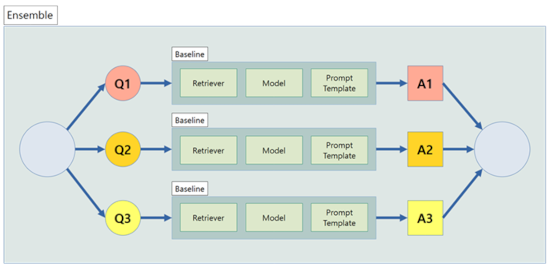

**Possible problem secnario:** The questions inputted into the Baseline model can be abstract, general, or ambiguous. 

- In such instances, it's challenging for the Baseline model to provide a satisfactory answer
- Using Ensemble, Gemma can correct even if one of several answers is wrong
- In Ensemble Model, the model refines the initial question from various perspectives, creating multiple answers.

#### The main algorithm performs the following steps
- **Ensemble Model**
    - **Question Exploration**: Finds three pivot questions related to the initial question.
      - (1) `Foundational Question`: Understand the basic principles or definitions
      - (2) `Relative Question`: Relational topics
      - (3) `Application Question`: Practical applications
    - **Retrieval Document**: Retrieve documents for each question
    - **Answer Update**: Answer each questions using searched documents
    - **Summarization**: Answer the original question based on multiple answers
      - Answer the original question in the form of an essay report.
      - (1) `Foundational Aspect`: Essential definitions
      - (2) `Relative Aspect`: Related topics
      - (3) `Application Aspect`: Rractical applications

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Ensemble Model Implementation</h3>
</div>

### 2.1. Ensemble Model Implementation

In [ ]:
class GemmaQuestionGenerator(GemmaBaseWrapper):
    def __init__(self, model, question_prompt_template, answer_prompt_template, 
                 max_new_tokens=800, temperature=0.8, top_k=5, top_p=0.85):
        super().__init__(model=model, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k, top_p=top_p, )

        """
        Initializes the GemmaQuestioner class which inherits from GemmaBaseWrapper.
        This class handles formatting and generation of prompts for question answering.
        
        :param model: The model used for generating responses.
        :param question_prompt_template: An instance of CharacterPromptTemplate for formatting questions.
        :param answer_prompt_template: An instance of CharacterPromptTemplate for beginning-of-sentence text generation.
        """
        super().__init__(model=model, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k, top_p=top_p)
        
        self.question_prompt_template = question_prompt_template
        self.answer_prompt_template = answer_prompt_template

    def construct_prompts(self, initial_question):
        """
        Constructs and formats three different prompts to generate questions exploring various aspects of a topic.
        """
        aspects = [
            "Foundational Question: What question can we ask to understand the basic principles or definitions related to this topic?",
            "Relative Question: What question can help us explore how the concepts related to this topic work?",
            "Application Question: What question should we ask to uncover the practical applications or impacts of this topic?"
        ]
        
        formatted_prompts = []
        for aspect in aspects:
            prompt = f"Given the question '{initial_question}', please formulate one new question that simplifies the complexity of the original question by focusing on a different aspect of the topic:\n\n1. {aspect}"
            formatted_prompt = self.question_prompt_template.formatted_text(prompt)
            formatted_prompt += self.answer_prompt_template.bos_formatted_text('**Question:**\n\n1.')
            formatted_prompts.append(formatted_prompt)
    
        return formatted_prompts
        
    def generate_question(self, question):
        """
        Generates questions based on the original question..
        """
        formatted_prompts = self.construct_prompts(question)
        answers = self.generate(formatted_prompts)
        answers = [answer.strip() for answer in answers]
        return answers


In [ ]:
class GemmaEnsembleModel:
    def __init__(self, model, question_prompt_template, answer_prompt_template,
                 retriever, search_k=10,
                 max_new_tokens=800, temperature=0.8, top_k=5, top_p=0.85):

        """
        Initializes the GemmaBaseQA class which inherits from GemmaBaseWrapper.
        This class handles formatting and generation of prompts for question answering.
        
        :param model: The model used for generating responses.
        :param question_prompt_template: An instance of CharacterPromptTemplate for formatting questions.
        :param answer_prompt_template: An instance of CharacterPromptTemplate for beginning-of-sentence text generation.
        :param retriever: An instance of FaissRetriever for fetching relevant documents.
        :param search_k: Number of documents to retrieve for each question.
        """

        self.question_generator = GemmaQuestionGenerator(model, 
                                     question_prompt_template=question_prompt_template, answer_prompt_template=answer_prompt_template,
                                     max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k, top_p=top_p)

        self.base_qa = GemmaBaseQA(model, 
                                     question_prompt_template=question_prompt_template, answer_prompt_template=answer_prompt_template,
                                     retriever=retriever, search_k=search_k,
                                     max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k , top_p=top_p)
        

    def generate_questions_and_answers(self, initial_question):
        # Generate answers and questions for given questions.
        generated_questions = self.question_generator.generate_question(initial_question)
        answers = self.base_qa.generate_answer_with_rag(generated_questions)
        return generated_questions, answers

    def compile_output(self, questions, answers):
        # Accumulate answers.
        compiled_output = ""
        for index, question in enumerate(questions):
            compiled_output += f"{question}:\n{answers[index]}\n"
        return compiled_output

    def generate_comprehensive_answer(self, question, compiled_output, text_book=None, bos_text=""):
        # Creates a prompt for Ensemble.
        comprehensive_prompt = f"""
        Given the detailed information above passage, please provide a clear essay report with sublandmarks to the following question related to data science: '{question}'. In crafting your response, please ensure that it addresses the following conditions:
        
        1. Foundational Aspect: Incorporate an explanation that could be framed as an answer to a foundational question, such as 'What basic principles or definitions are essential to understanding this topic?'

        2. Relative Aspect: Include insights that answer a relative question like 'How do the concepts related to this topic work or interact with each other?'

        3. Application Aspect: Conclude with information that responds to an application question, for example, 'What are the practical applications or impacts of this topic in various fields?'

        Please provide an essay report to the following question related to data science: '{question}'
        This approach should help elucidate the topic's core principles, its operational mechanisms, and its real-world relevance or applications.
        """
        comprehensive_answer = self.base_qa.generate_answer([comprehensive_prompt], [compiled_output], text_book=text_book, bos_text=bos_text)
        return comprehensive_answer

    def generate_answer(self, question, text_book=None, bos_text="Sure, here's the essay report that addresses the question:\n\n"):
        generated_questions, answers = self.generate_questions_and_answers(question)
        compiled_output = self.compile_output(generated_questions, answers)
        final_answer = self.generate_comprehensive_answer(question, compiled_output, text_book=text_book, bos_text=bos_text)
        return final_answer[0]

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Examples of Ensemble Model Answers</h3>
</div>

### 2.2. Examples of Ensemble Model Answers

#### (a) Generate Answer using GemmaEnsembleModel

In [ ]:
# Example (answer: user_template as answer, question: gemma_template by experiment)
user_template = CharacterPromptTemplate(name="User", tag="user")
gemma_template = CharacterPromptTemplate(name="Gemma", tag="model")

ensemble_model = GemmaEnsembleModel(model, 
                                   question_prompt_template=gemma_template, answer_prompt_template=user_template,
                                   retriever=searchRetriever, search_k=10,
                                   max_new_tokens=800, temperature=0.8, top_k=5, top_p=0.85)

In [ ]:
question = 'What is classification? Which models would you use to solve a classification problem?'
ensemble_answer = ensemble_model.generate_answer(question)

In [ ]:
display_question_answers(question, 
                         answers=[ensemble_answer], 
                         tags=['Ensemble Model Answer'])

#### (b) Precomputed Example

In [ ]:
# Example no.25
idx = 25
question, base_answer, base_answer_with_rag, ensemble_answer, chain_answer = results_df.iloc[idx]
display_question_answers(question, 
                         [base_answer, ensemble_answer, base_answer_with_rag], 
                         tags=['Base Answer', 'Ensemble Answer', 'Base Answer with RAG'])

In [ ]:
# Example no.42
idx = 42
question, base_answer, base_answer_with_rag, ensemble_answer, chain_answer = results_df.iloc[idx]
display_question_answers(question, 
                         [base_answer, ensemble_answer, base_answer_with_rag], 
                         tags=['Base Answer', 'Ensemble Answer', 'Base Answer with RAG'])

In the Ensemble model, three baselines are calculated as batches.

With batch calculations, good results can be obtained in a similar time to the baseline.

<div class="alert alert-block alert-success">
<b>Note:</b> I tried several things based on this Ensemble model.
</div>

<div style="background-color: #4791db; color: white; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">3. Algorithm 2: Search and SWOT Kaggle Competitions</h2>
</div>

## 3. Algorithm 2: Search and SWOT Kaggle Competitions

In this section, we introduce applications utilizing `Kaggle Meta data` [9]:

- Using BM25 document search to find Completed Kaggle Competitions
- Conducting SWOT analysis on the competitions identified through the search

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Prepare Kaggle Competition-Message Data</h3>
</div>

### 3.1. Prepare Kaggle Competition-Message Data

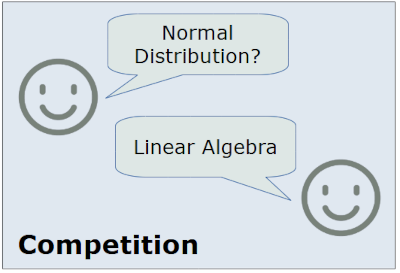

In every `competition`, there are `numerous messages` from participants. 

These messages can be used to recommend previous competitions to users. 
- Okapi BM25 search allows us to find related Kaggle competitions based on messages.
- The first step is preprocess messages from Kaggle Meta data
- In this method, the competition is thought of as a document containing written messages.

In [ ]:
def clean_text(text):
    # Convert text to string explicitly to avoid issues
    if text is None:
        return ''
    
    text = str(text).strip()
    if not text:
        return ''
    
    try:
        # Using BeautifulSoup to parse and extract text if HTML tags are expected
        text = BeautifulSoup(text, "lxml").get_text(separator=' ')
    except Exception as e:
        return ''  

    # Removing emojis and non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

In [ ]:
def kaggle_meta_process(forum_messages_df, forum_topics_df, competitions_df, medal=2.0, min_length=500):
    # Filter competition forum_topics
    comp_id_list = competitions_df.ForumId.tolist()
    competition_forum_topics_df = forum_topics_df[forum_topics_df.ForumId.isin(comp_id_list)].reset_index(drop=True)
    
    # Filter forum_messages len, Medal
    forum_messages_df = forum_messages_df[(forum_messages_df.Medal <= medal)].reset_index(drop=True)
    forum_messages_df = forum_messages_df[(forum_messages_df.Message.str.len() > min_length)].reset_index(drop=True)
    
    # Merge and Filter
    merged_messages_df = pd.merge(forum_messages_df, competition_forum_topics_df, left_on='ForumTopicId', right_on='Id')
    merged_messages_df['Message'] = merged_messages_df['Message'].apply(clean_text)
    merged_messages_df = merged_messages_df[(merged_messages_df.Message.str.len() > min_length)].reset_index(drop=True)
    merged_messages_df = merged_messages_df[['ForumId', 'Message']]

    # Combine Messages
    combined_merge_messages_df = merged_messages_df.groupby('ForumId')['Message'].agg(' '.join).reset_index()
    competitions_messages = pd.merge(combined_merge_messages_df, competitions_df, on='ForumId')
    competitions_messages['Link'] = "https://www.kaggle.com/competitions/"+competitions_messages['Slug']

    #Create Period
    enable_date = pd.to_datetime(competitions_messages['EnabledDate'], format='%m/%d/%Y %H:%M:%S').dt.to_period('M').astype(str)
    deadline_date = pd.to_datetime(competitions_messages['DeadlineDate'], format='%m/%d/%Y %H:%M:%S').dt.to_period('M').astype(str)
    competitions_messages['Period'] = competitions_messages['EnabledDate'].astype(str) + ' - ' + competitions_messages['DeadlineDate'].astype(str)
    competitions_messages['Period'] = enable_date + ' - ' + deadline_date
    
    competitions_messages = competitions_messages[['ForumId', 'Title', 'Subtitle', 'EvaluationAlgorithmName', 'Link', 'Period', 'Message']]
    competitions_messages = competitions_messages.sort_values(by='ForumId', ascending=False).reset_index(drop=True)

    return competitions_messages

In [ ]:
competition_csv_path = CONFIG.competition_csv_path
forum_topic_csv_path = CONFIG.forum_topic_csv_path
forum_messages_csv_path = CONFIG.forum_messages_csv_path

forum_messages_cols = ['ForumTopicId', 'Message', 'Medal']
forum_topics_cols = ['Id', 'ForumId']
competitions_cols = ['Slug', 'Title', 'Subtitle', 'ForumId', 'EvaluationAlgorithmName', 'EnabledDate', 'DeadlineDate']

competitions_df = pd.read_csv(competition_csv_path, usecols=competitions_cols)
forum_topics_df = pd.read_csv(forum_topic_csv_path, usecols=forum_topics_cols)
forum_messages_df = pd.read_csv(forum_messages_csv_path, usecols=forum_messages_cols)

In [ ]:
# Message medal: 1 gold, 2 silver 3 bronze
competitions_messages = kaggle_meta_process(forum_messages_df, forum_topics_df, competitions_df, medal=1.0, min_length=1000)
gc.collect()

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Competition Search (Okapi BM25)</h3>
</div>

### 3.2. Competition BM25 Search (Okapi BM25)

We apply the Okapi BM25 model with the Tokenizer of the Gemma model.

The Gemma model's Tokenizer worked quickly and well, and was efficient in finding related documents using the BM25 algorithm.

In [ ]:
class BM25KaggleSearch:
    def __init__(self, tokenizer, document_df, batch_size=5):
        self.tokenizer = tokenizer  # Tokenizer for text processing
        self.batch_size = batch_size  # Batch size for tokenizing documents
        
        # Initialize variables to hold documents, user messages, tokenized documents, and BM25 model
        self.documents = None
        self.user_messages = None
        self.tokenized_documents = None
        self.bm25 = None
        
        # Update documents with the provided DataFrame
        self.update_documents(document_df)

    def update_documents(self, document_df):
        # Extract relevant columns from the DataFrame
        self.documents =  document_df[['ForumId', 'Title', 'Subtitle','EvaluationAlgorithmName', 'Link', 'Period']]
        self.user_messages = document_df[['ForumId', 'Message']]
        
        # Combine all messages into a single list of strings
        combined_text = [str(x) for x in (document_df['Message']).tolist()]
        
        # Tokenize the combined text in batches
        self.tokenized_documents = []
        for i in tqdm(range(0, len(combined_text), self.batch_size)):
            batch = combined_text[i:i+self.batch_size]
            self.tokenized_documents.extend(self.tokenizer(batch)['input_ids'])
        
        # Create a BM25 model with the tokenized documents
        self.bm25 = BM25Okapi(self.tokenized_documents)

    def get_sample_message(self, forum_id, segment_length=1000, num_samples=4):
        # Get the message text for the given forum ID
        message_text = self.user_messages.loc[self.user_messages.ForumId == forum_id, 'Message']
        if len(message_text) == 0:
            return ""
        message_text = message_text.iat[0]
        
        # If the message text is shorter than the total sample length, return the entire text
        if len(message_text) <= (num_samples*segment_length):
            return message_text
        
        # Otherwise, randomly sample segments from the text
        sample_message = ""
        for _ in range(num_samples):
            start_index = random.randint(0, len(message_text) - segment_length)
            sample_message += message_text[start_index:start_index + segment_length]
            sample_message += '\n'
        return sample_message
        
    def search(self, queries, k=5):
        # If a single query is provided, convert it to a list
        if isinstance(queries, str):
            queries = [queries]
        
        # Tokenize the queries in batches
        tokenized_queries = []
        for i in range(0, len(queries), self.batch_size):
            batch = queries[i:i+self.batch_size]
            tokenized_queries.extend(self.tokenizer(batch)['input_ids'])
        
        # Get the top k results for each query
        results = []
        for query in tokenized_queries:
            doc_scores = self.bm25.get_scores(query)
            top_k_indices = np.argpartition(doc_scores, -k)[-k:]
            top_k_pairs = sorted([(self.documents.iloc[i].to_dict(), doc_scores[i]) for i in top_k_indices if doc_scores[i]], 
                                 key=lambda x: x[1], reverse=True)
            results.append(top_k_pairs)
            
        return results

In [ ]:
tokenizer = model.tokenizer
bm25_kaggle_searcher = BM25KaggleSearch(tokenizer, document_df=competitions_messages)

In [ ]:
topic = 'Graph Algorithm with Traveling Salesman Problem'
search_results = bm25_kaggle_searcher.search(topic, k=5)[0]
display_competition_search_results(topic, search_results)

In [ ]:
topic = 'Image Classification'
search_results = bm25_kaggle_searcher.search(topic, k=5)[0]
display_competition_search_results(topic, search_results)

In [ ]:
topic = 'Spectrogram Analysis'
search_results = bm25_kaggle_searcher.search(topic, k=5)[0]
display_competition_search_results(topic, search_results)

The BM25 model finds past competitions very quickly.

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Competition SWOT Summarize</h3>
</div>

### 3.3. Competition SWOT Summarize

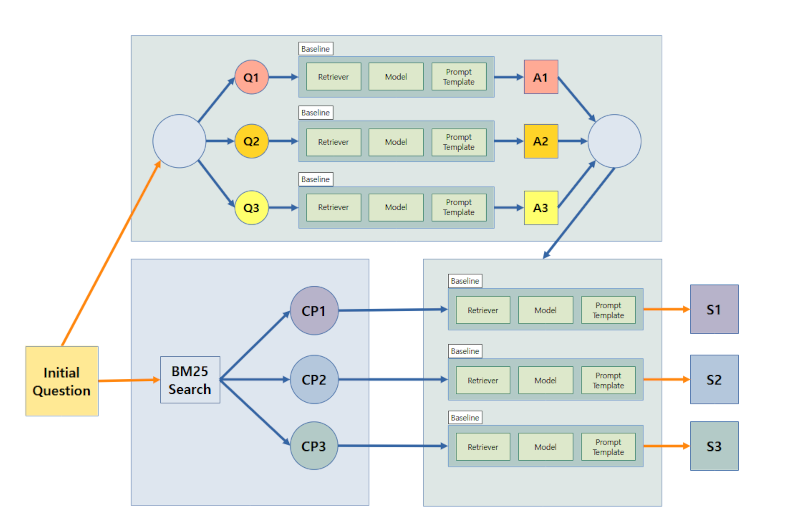

(1) Based on the user's question, we use the BM25 algorithm to find relevant competitions. 

(2) We then use the Gemma model to create a SWOT summary report from the Competition Forum Messages (Random Selection 4000 words)

- To approximately determine what the user's question involves, we use an Ensemble model to prepare responses in advance.
- We compile the SWOT report using a template designed for SWOT analysis, incorporating pre-prepared responses and sampled messages from user forums.es.

In [ ]:
class CompetitionAnalyzer:
    def __init__(self, ensemble_model, searcher):
        self.ensemble_model = ensemble_model  # The model used for generating questions and answers
        self.searcher = searcher  # The searcher used for finding relevant competitions and user messages
        
        # The template for the SWOT analysis questions
        self.swot_template = """
        Could you perform a SWOT Summarization for Competition based on User Messages?: {competition}. Please consider the following SWOT aspects:
        - Summarization: What are the main topic of this competition?
        - Strengths: What are the inherent advantages or positive attributes?
        - Weaknesses: What are the limitations or areas for improvement?
        - Opportunities: What external factors could be leveraged for benefit?
        - Threats: What external challenges could impact success?
        """

    def format_competition_info(self, competition_info, user_message):
        # Formats the competition information and user message into a single string
        competition_details = f"Title: {competition_info['Title']}, Subtitle: {competition_info['Subtitle']}, Metric: {competition_info['EvaluationAlgorithmName']}, Period: {competition_info['Period']}"
        formatted_text = f"Competition: {competition_details}\nUser Messages: {user_message}"
        return formatted_text

    def get_search_results(self, questions, k=3):
        # Returns the top k search results for the given questions
        return self.searcher.search(questions, k)

    def get_user_messages(self, forum_ids):
        # Returns a sample user message for each forum ID
        return [self.searcher.get_sample_message(forum_id) for forum_id in forum_ids]

    def analyze_competition(self, initial_question):
        # Performs the full analysis process for the given initial question
        # Returns the search results and the outputs of the analysis
        
        search_results = self.get_search_results(initial_question)[0]
        competition_info_list = [result[0] for result in search_results]
        forum_ids =  [info['ForumId'] for info in competition_info_list]
        user_messages = self.get_user_messages(forum_ids)
        formatted_competition_info = [self.format_competition_info(info, message) for info, message in zip(competition_info_list, user_messages)]
        swot_questions = [self.swot_template.format(competition=info) for info in formatted_competition_info]
        common_answer = self.ensemble_model.generate_answer(initial_question)
        outputs = self.ensemble_model.base_qa.generate_answer(swot_questions, text_book=common_answer)
        return search_results, outputs

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Examples of Search and SWOT</h3>
</div>

### 3.4. Examples of Search and SWOT

#### (a) Define Competition Analyzer

In [ ]:
competition_analyzer = CompetitionAnalyzer(ensemble_model, bm25_kaggle_searcher)

#### (b) Search and SWOT Example

In [ ]:
# Example
init_question = "I like to solve puzzle like problems."
search_results, outputs = competition_analyzer.analyze_competition(init_question)

In [ ]:
# Search Result
display_competition_search_results(init_question, search_results)

In [ ]:
#SWOT Analysis
display_question_answers(init_question, outputs, tags= [comp_info[0]['Title'] for comp_info in search_results])

We performed a **SWOT analysis** of `past competitions` by randomly extracting chunks of messages and summarizing them with Gemma.

<div style="background-color: #4791db; color: white; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">4. Algorithm 3: Chain of Ensemble Model (Answer Refinement)</h2>
</div>

## 4. Chain of Ensemble Model (Answer Refinement)

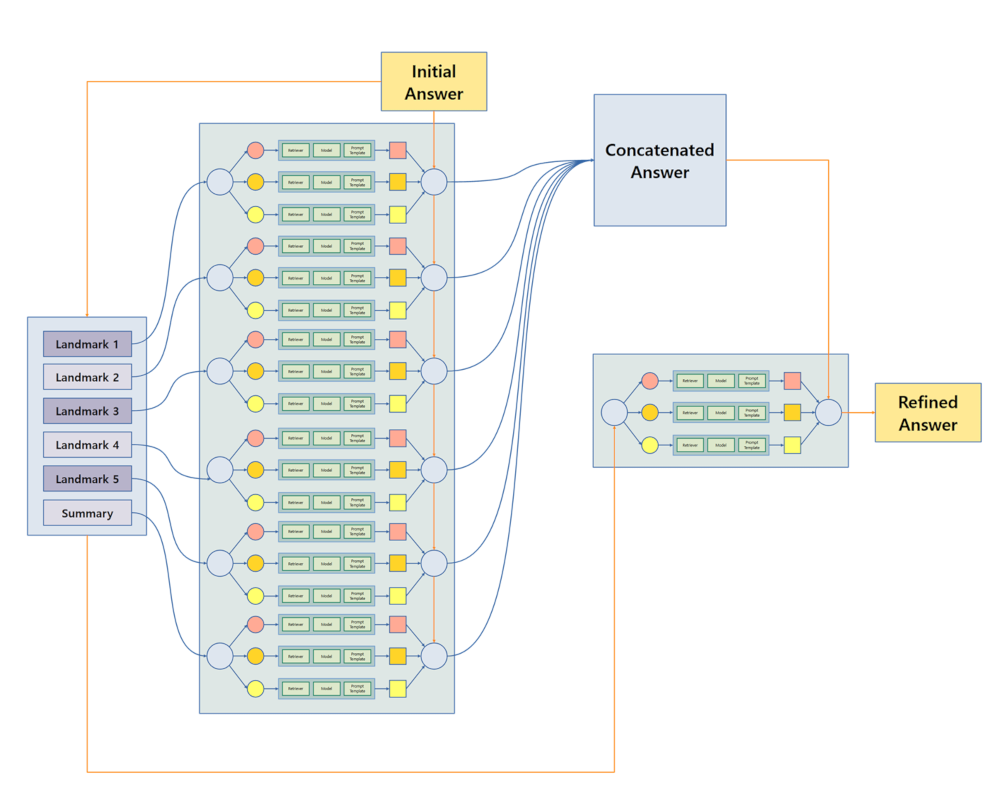

I tried a structure that stacked ensemble models. I called this Chain of Ensemble.
- The function is to research and summarize the detailed topics of the document
- It was designed to be used in creating long presentation scripts

**How It Works:**
- Assume we start with an initial document. (Like Presentation Slide)
- Our goal is to make long explanation from short document.
- (1) Find the main landmark points (summarization lines)
- (2) Each landmark points is input into a separate Ensemble Model 
- (3) Answers are generated sequentially
- (4) Answer from a previous step being passed to the next step using `BOS Few-Shot Example`.
- (3) Aggregate these answers using an Ensemble Model

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Chain of Ensemble Model Implementation</h3>
</div>

### 4.1. Chain of Ensemble Model Implementation

- First, we extract landmarks from the given text using the `extract_landmarks` method.
- We then prompt the model with these landmarks:
    - The model composes an essay about the specified landmark.
- The answers generated by the model are saved and passed to the next step:
    - This process escalates (questions, answers) in a manner similar to a Few-Shot prompt.
    - In the Gemma model, the text tends to become shorter, which might be an attempt by the model to adhere to any character limits it learned during training.
    - We preserve the length of the model’s responses by incorporating them into subsequent Few-Shot prompts.

In [ ]:
class ChainEnsembleModel:
    def __init__(self, ensemble_model):
        # The constructor takes an ensemble model as input and stores it as an instance variable.
        self.ensemble_model = ensemble_model

    def split_text_to_items_list(self, text):
        # This method takes a string of text as input, splits it into lines, and returns a list of the non-empty lines.
        items = [line.strip() for line in text.splitlines() if len(line) > 0]
        return items

    def parse_agent_answer(self, total_explanation):
        # This method takes a list of explanations, each consisting of a landmark and its explanation,
        # and returns a string where each explanation is formatted as a Markdown section.
        return ''.join([f"**{item[0]}**\n\n{item[1]}\n\n" for item in total_explanation])

    def extract_landmarks(self, text):
        # This method uses the ensemble model to generate a list of landmarks for a given text.
        # It returns a list of landmarks, each of which is a string.
        raw_answer = self.ensemble_model.base_qa.generate_answer(['what are five main summarization landmarks of this passage topic as an essay?'],
                                                                [text], bos_text="Sure, here are the landmarks of the passage:\n")
        landmarks = self.split_text_to_items_list(raw_answer[0])
        landmarks.append('Summary')
        return landmarks

    def refine_answer(self, text):
        # This method takes a text as input, extracts its landmarks, and generates an explanation for each landmark.
        # It returns a report that includes the explanations for all landmarks.
        landmarks = self.extract_landmarks(text)
        
        total_explanation = []
        for idx, landmark in tqdm(enumerate(landmarks), total=len(landmarks)):
            prefix = ''.join([f"Sure, here's an answer to the question:\n\n{item[0]}:\n\n{item[1]}\n\n" for item in total_explanation])
            bos_text = prefix + f"Sure, here's the summary you requested:\n\n{landmark}:\n\n"
            
            if idx == len(landmarks) - 1:
                explanation = self.ensemble_model.base_qa.generate_answer('Summarize this Document', text_book=text,
                                                                         bos_text=bos_text)[0]
            else:    
                bos_text = prefix + f"Sure, here's an answer to the question:\n\n{landmark}:\n\n"
                explanation = self.ensemble_model.generate_answer(landmark, text_book=text,
                                                                  bos_text=bos_text)
            total_explanation.append((landmark, explanation))

        total_report = self.parse_agent_answer(total_explanation)
        total_landmarks = ', '.join(landmarks)
        report = self.ensemble_model.generate_answer(total_landmarks, text_book=total_report)
        return report

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Examples of Chain Ensemble Model</h3>
</div>

### 4.2. Examples of Chain Ensemble Model

#### (a) Define Chain of Ensemble variable

In [ ]:
chain_ensemble_model = ChainEnsembleModel(ensemble_model)

In [ ]:
example_short_text_path = CONFIG.example_short_text_path
example_text_df = pd.read_csv(example_short_text_path)

In [ ]:
short_text, chain_answer_refine = example_text_df.iloc[0]

In [ ]:
chain_answer_one_beam =  chain_ensemble_model.refine_answer(short_text)

In [ ]:
display_question_answers("Short Text Refinement", 
                         answers=[short_text, chain_answer_one_beam], 
                         tags=['Text', 'Chain Ensemble Model Answer'])

#### (b) Example Short Text Refinment

<div class="alert alert-block alert-info">
<b>Note:</b> Since it takes times, we can look at the pre-calculated data on the local PC.
</div>

In [ ]:
short_text, chain_answer_refine = example_text_df.iloc[0]
display_question_answers("Short Text Refinement", 
                         answers=[short_text, chain_answer_refine], 
                         tags=['Text', 'Chain Ensemble Model Answer (beam_width=2)'])

In [ ]:
short_text, chain_answer_refine = example_text_df.iloc[1]
display_question_answers("Short Text Refinement", 
                         answers=[short_text, chain_answer_refine], 
                         tags=['Text', 'Chain Ensemble Model Answer (beam_width=2)'])

In [ ]:
short_text, chain_answer_refine = example_text_df.iloc[2]
display_question_answers("Short Text Refinement", 
                         answers=[short_text, chain_answer_refine], 
                         tags=['Text', 'Chain Ensemble Model Answer (beam_width=2)'])

This result was achieved by stacking the Ensemble model like a chain.

<div style="background-color: #4791db; color: white; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">Performance Review</h2>
</div>

## 5. Performance Review

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Data Science Answers</h3>
</div>

### 5.1. Data Science Answers

In this section, we will compare baseline answer, baseline answer (RAG), ensemble answer, and chain answer (refinement).

Review answers for 166 pre-calculated data science questions

In [ ]:
# Example no.42
idx = 42
question, base_answer, base_answer_with_rag, ensemble_answer, chain_answer = results_df.iloc[idx]
display_question_answers(question, 
                         [base_answer, base_answer_with_rag, ensemble_answer, chain_answer], 
                         tags=['Base Answer', 'Base Answer with RAG', 'Ensemble Answer', 'Refinement Chain Answer'])

We think **Ensemble** response is the best of the four. 
- **base answer:** The base answer says a word related to the question, and generating the conversation that is natural.
- **base answer with rag:** The baseline using RAG has vulnerabilities because it relies too much on documentation.
- **ensemble answer:** Ensemble model writes a somewhat balanced answer
- **refinement chain answer:** This is a refinement of the ensemble model's answer. It trying to summarize and explain the article. (Not answer the question)

In [ ]:
# Example no.68
idx = 68
question, base_answer, base_answer_with_rag, ensemble_answer, chain_answer = results_df.iloc[idx]
display_question_answers(question, 
                         [base_answer, base_answer_with_rag, ensemble_answer, chain_answer], 
                         tags=['Base Answer', 'Base Answer with RAG', 'Ensemble Answer', 'Refinement Chain Answer'])

We think **Ensemble** and **Refinement** response are the best of the four. 
- **base answer:** It explain about a general theory related to tree search.
- **base answer with rag:** It focus too much on the document and give strange answers.
- **ensemble answer:** This model starts with an introduction and briefly answers and summarizes in the body. That seems like a good answer.
- **refinement chain answer:** Thematic consistency seems to have improved more in the conclusion than in the Ensemble model's answers.

In [ ]:
# Example no.87
idx = 87
question, base_answer, base_answer_with_rag, ensemble_answer, chain_answer = results_df.iloc[idx]
display_question_answers(question, 
                         [base_answer, base_answer_with_rag, ensemble_answer, chain_answer], 
                         tags=['Base Answer', 'Base Answer with RAG', 'Ensemble Answer', 'Refinement Chain Answer'])

We think **Ensemble** response is the best of the four. 
- **base answer:** Baseline model makes an irrelevant explanation.
- **base answer with rag:** Baseline (with RAG) obtains false information from RAG and tells lies with confidence.
- **ensemble answer:** The Ensemble model had the right direction.
- **refinement chain answer:** Refinement The answer is not the answer to the question. The model provides an overall description of the sigmoid.

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Competition Search and Summary</h3>
</div>

### 5.2. Competition Search and Summary

We examine whether the model recommends competitions and performs a SWOT analysis based on user intent.

In [ ]:
init_question = "I want to apply bagging method in classification problem."
search_results, outputs = competition_analyzer.analyze_competition(init_question)
display_competition_search_results(init_question, search_results)
display_question_answers(init_question, outputs, tags= [comp_info[0]['Title'] for comp_info in search_results])

- Competition 1: The model performed a SWOT analysis in response to user questions. The recommendations appear appropriate and generally correct..
- Competition 2: It's generally acceptable except for a few mistakes in Threats.
- Competition 3: This also answers the first question, Bagging. It seems pretty good.

In [ ]:
init_question = "What is the competition where I can learn the ensemble method?"
search_results, outputs = competition_analyzer.analyze_competition(init_question)
display_competition_search_results(init_question, search_results)
display_question_answers(init_question, outputs, tags= [comp_info[0]['Title'] for comp_info in search_results])

It all feels pretty reasonable. But since I don't know the details of the competition, it's difficult to evaluate.

In [ ]:
init_question = "I want to solve the traveling salesman problem."
search_results, outputs = competition_analyzer.analyze_competition(init_question)
display_competition_search_results(init_question, search_results)
display_question_answers(init_question, outputs, tags= [comp_info[0]['Title'] for comp_info in search_results])

Santa2022 seems very accurate in the Weakness section. It felt like a competition where I didn't even know what to do. Particularly, variations such as Constraint were added, and I failed to connect them with the TSP ideas until the later stages. As a result, it seems various methods were applied, such as the Backtracking method or the K-opt method. It was a good competition for me because I was unfamiliar with the problem, so I actively observed many people's opinions.

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Conclusion</h3>
</div>

### 5.3. Conclusion

- The `Ensemble` model was assessed to have a computation time similar to the baseline model, and its performance was clearly good.

- The `Refinement` model can organize and explain a given text from a general perspective.

- The `competition analysis` model uses BM25 to efficiently find related competitions and conducts a SWOT analysis on them through user messages. 
  - This SWOT analysis reflects the user's perspective on the question.

<div style="background-color: #4791db; color: white; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">Wrap all Methods: Gemma Assistant for Kaggle</h2>
</div>

## 6. Wrap All Methods: Gemma Question Answering System for Kaggle

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Question Answering System Implementation</h3>
</div>

### 6.1. Question Answering System Implementation

Combines the features of all models into Question Answering System class.

In [ ]:
class QuestionAnsweringSystem:
    def __init__(self, model, question_prompt_template, answer_prompt_template,
                 retriever, bm25_kaggle_searcher, search_k=10, 
                 max_new_tokens=800, temperature=0.8, top_k=5, top_p=0.85):
 
        self.ensemble_model = GemmaEnsembleModel(
            model=model,
            question_prompt_template=question_prompt_template, 
            answer_prompt_template=answer_prompt_template,
            retriever=retriever, 
            search_k=search_k,
            max_new_tokens=max_new_tokens, 
            temperature=temperature,
            top_k=top_k,
            top_p=top_p
        )
  
        self.chain_ensemble_model = ChainEnsembleModel(self.ensemble_model)
        self.competition_analyzer = CompetitionAnalyzer(self.ensemble_model, bm25_kaggle_searcher)

    def generate_base_answer(self, questions, documents=None, text_book=None, bos_text=""):
        return self.ensemble_model.base_qa.generate_answer(questions, documents=documents, text_book=text_book, bos_text=bos_text)
        
    def generate_base_answer_with_rag(self, questions, text_book=None, bos_text=""):
        return self.ensemble_model.base_qa.generate_answer_with_rag(questions, text_book=text_book, bos_text=bos_text)

    def generate_ensemble_answer(self, question, text_book=None, bos_text="Sure, here's the essay report that addresses the question:\n\n"):
        return self.ensemble_model.generate_answer(question, text_book=text_book, bos_text=bos_text)
    
    def refine_answer(self, text):
        return self.chain_ensemble_model.refine_answer(text)

    def generate_relative_question(self, question):
        return self.ensemble_model.question_generator.generate_question(question)

    def extract_landmarks(self, text):
        return self.chain_ensemble_model.extract_landmarks(text)

    def recommend_competition(self, question):
        return self.competition_analyzer.analyze_competition(question)

    def get_relative_competitions(self, questions, k=3):
        return self.competition_analyzer.get_search_results(questions, k=k)

#### Personal Insight
- (User, Model prompt exchange):
   - I thought that if the quality of the user input data was different from the quality of the output data, then simply changing the prompt could affect the answer quality.
   - It's just a hypothesis, but I believe it maybe hold.

In [ ]:
user_template = CharacterPromptTemplate(name="User", tag="user") # For answer
gemma_template = CharacterPromptTemplate(name="Gemma", tag="model") # For question
QAS = QuestionAnsweringSystem(model, 
                        question_prompt_template=gemma_template, answer_prompt_template=user_template,
                        retriever=searchRetriever, bm25_kaggle_searcher=bm25_kaggle_searcher,
                        search_k=10, max_new_tokens=800, temperature=0.8, top_k=5, top_p=0.85)

In [ ]:
#Competition dictionary output
QAS.get_relative_competitions("Competitions related to LLM")

In [ ]:
#Ensemble Answer
init_question = "What is the law of large numbers?"
ensemble_answer = QAS.generate_ensemble_answer(init_question)
display_question_answers(init_question, [ensemble_answer])

<div style="background-color: #4791db; color: white; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">Application 1: Create a presentation script</h2>
</div>

## 7. Application 1: Create a presentation script

The main goal of the Chain of Ensemble in this project was to create a script that could be presented on YouTube.

In the process of creating a spoken script based on the given presentation materials, the concept of a Chain of Ensemble model emerged.

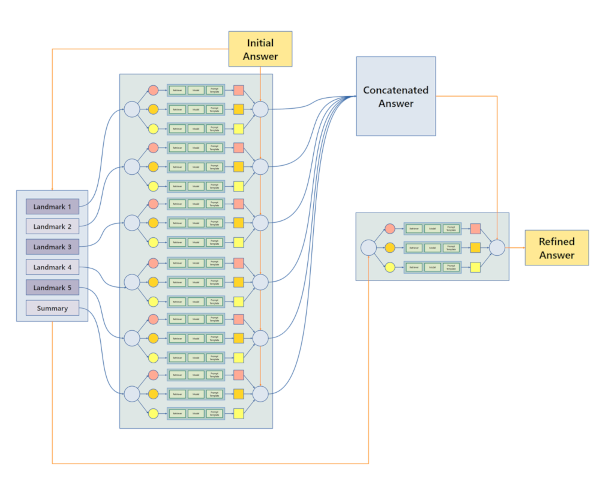

<div style="background-color: #e0f7fa; color: black; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h3 style="margin: 0;">Generate Transcripts</h3>
</div>

### 7.1. Generate Transcripts

In [ ]:
import fitz  # PyMuPDF
from PIL import Image
import io
import base64

In [ ]:
# Visualization
def display_pdf(doc, display_width='80'):
    """
    render pdf doc to images
    """
    page_images = []  # To hold the binary data of all page images
    
    for page in doc:
        pix = page.get_pixmap()
        img_data = pix.tobytes("png")  # Get the PNG binary data
        encoded_img = base64.b64encode(img_data).decode('utf-8')
        page_images.append(encoded_img)
    
    # Generate HTML for displaying images
    images_html = ''.join([f'<img src="data:image/png;base64,{img}" style="height:auto; max-height:260px; margin:5px; border: 1px solid black;">' for img in page_images])
    display_html = f'<div style="width: {display_width}%; height: 300px; overflow-x: scroll; white-space: nowrap;">{images_html}</div>'

    # Display
    display(HTML(display_html))

#Visualization 2
def display_answers_pdf(answers=None, doc=None):
    """
    render scripts (answers) and pdf doc to images
    """
    if answers is None:
        answers = []
    tags = [f"Page {i}" for i in range(1, len(answers)+1)]

    images = []
    if doc:
        for page in doc:
            pix = page.get_pixmap()
            img_data = pix.tobytes("png")  # Get the PNG binary data
            encoded_img = base64.b64encode(img_data).decode('utf-8')
            images.append(encoded_img)
        
    # Ensure tags and images lists are same length as answers
    if len(images) < len(answers):
        images += [None] * (len(answers) - len(images))
    
    # Add headers and answers
    html_content = '<div style="display: flex; overflow-x: auto;">'
    for tag, answer, image in zip(tags, answers, images):
        answer_html = f"{add_colored_lines_with_markdown(answer, color='lightblue')}" if answer else "No answer provided."
        image_html = f'<img src="data:image/png;base64,{image}" style="height:auto; max-height:260px; margin:5px; border: 1px solid black;">' if image else ""
        html_content += f'''
        <div style="flex: 0 0 600px; min-width: 600px; border: 1px solid #ccc; margin: 5px; padding: 10px;">
            {image_html}
            <h3 style="text-align:left;">{tag}</h3>
            <div style="text-align:left;">{answer_html}</div>
        </div>
        '''
    html_content += '</div>'
    
    display(HTML(html_content))

#### Prepare Presentation Slide

In [ ]:
pdf_path = CONFIG.sample_presentation_pdf_path
doc = fitz.open(pdf_path)
display_pdf(doc)

#### Run: Chian of Ensemble Model (refine_answer)

<div class="alert alert-block alert-success">
<b>Note:</b> It takes about 25 minutes to create a presentation scripts.
</div>

In [ ]:
pdf_slides = []
presentation_slides = []
for page_num in tqdm(range(len(doc))):
    page = doc.load_page(page_num)
    page_text = page.get_text()
    pdf_slides.append(page_text)

    presentation_text = QAS.refine_answer(page_text)
    presentation_slides.append(presentation_text)

In [ ]:
display_answers_pdf(answers=presentation_slides, doc=doc)

Thanks. I learned a lot from this competition.

<div style="background-color: #4791db; color: white; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">Conclusion</h2>
</div>

## 7. Conclusion

In conclusion, the integration of heuristic algorithms has significantly enhanced the Gemma model's capabilities to answer the data science queries. Through a development cycle involving iterative adjustments to prompts, model connections, and computational methods, we have improved the model's accuracy and efficiency. The outcome is a more dynamic and educational experience, demonstrating the model's potential in interactive learning environments.

<div style="background-color: #4791db; color: white; padding: 10px; margin-bottom: 10px; border-radius: 5px;">
    <h2 style="margin: 0;">Reference</h2>
</div>

## 8. Reference

1. **Prompt Gemma Like a Pro**:  
[https://www.kaggle.com/code/gpreda/prompt-gemma-like-a-pro](https://www.kaggle.com/code/gpreda/prompt-gemma-like-a-pro)

2. **Data Science AI Assistant with Gemma**:  
[https://www.kaggle.com/code/lucamassaron/data-science-ai-assistant-with-gemma-2b-it](https://www.kaggle.com/code/lucamassaron/data-science-ai-assistant-with-gemma-2b-it)

3. **Text Summarization with Gemma**:  
[https://www.kaggle.com/code/jacoporepossi/text-summarization-with-gemma](https://www.kaggle.com/code/jacoporepossi/text-summarization-with-gemma)

4. **Data Assistants with Gemma Discussion**:  
[https://www.kaggle.com/competitions/data-assistants-with-gemma/discussion/486111](https://www.kaggle.com/competitions/data-assistants-with-gemma/discussion/486111)

5. **Is it possible to run Gemma 7B in Kaggle Notebook?**:  
[https://www.kaggle.com/competitions/data-assistants-with-gemma/discussion/479773](https://www.kaggle.com/competitions/data-assistants-with-gemma/discussion/479773)

Additional Resources:

6. **Faiss (GitHub)**: [https://github.com/facebookresearch/faiss](https://github.com/facebookresearch/faiss)

7. **Rank BM25 (GitHub)**: [https://github.com/dorianbrown/rank_bm25](https://github.com/dorianbrown/rank_bm25)

8. **Embedding Model (Hugging Face)**: [https://huggingface.co/sentence-transformers/multi-qa-mpnet-base-dot-v1](https://huggingface.co/sentence-transformers/multi-qa-mpnet-base-dot-v1)

9. **Kaggle Meta (Kaggle)**: [https://www.kaggle.com/datasets/kaggle/meta-kaggle](https://www.kaggle.com/datasets/kaggle/meta-kaggle)

10. **270K Wikipedia STEM Articles (Kaggle)**: [https://www.kaggle.com/datasets/mbanaei/all-paraphs-parsed-expanded](https://www.kaggle.com/datasets/mbanaei/all-paraphs-parsed-expanded)

11. **Data Science Interview Q&A Treasury (Kaggle)**: [https://www.kaggle.com/datasets/memocan/data-science-interview-q-and-a-treasury](https://www.kaggle.com/datasets/memocan/data-science-interview-q-and-a-treasury)

12. **Gemma: Open Models Based on Gemini Research and Technology**: [https://arxiv.org/abs/2403.08295](https://arxiv.org/abs/2403.08295)
